# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# import pretty printing
from pprint import pprint

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

C:\Users\alexd\Anaconda3\envs\ipy27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\alexd\Anaconda3\envs\ipy27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
### STUDENT START ###

def P1(num_examples=5):
    names = newsgroups_train['target_names']
    for n in range(num_examples):
        print '\nSample number:', n, '\nClassification Label:', names[train_labels[n]]
        print '\nText:\n', train_data[n]
P1()

### STUDENT END ###


Sample number: 0 
Classification Label: comp.graphics

Text:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Sample number: 1 
Classification Label: talk.religion.misc

Text:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
### STUDENT START ###
def P2(train_data, dev_data):
    print 'PART (A):'
    v = CountVectorizer()
    features = v.fit_transform(train_data)
    print '\nSize of vocabulary:', len(v.vocabulary_)
    avg_nz_doc = 1.0 * np.sum([f.nnz for f in features]) / features.shape[0]
#     targets = newsgroups_train['target_names']
#     examples = {targets[i] : [] for i in range(len(targets))}
#     for i in range(len(train_labels)):
#         examples[targets[train_labels[i]]].append(features[i].nnz)
#     avg_nz_ex = {k: 1.0 * np.sum(v) / len(v) for k,v in examples.items()}
    print 'Average number of non-zero features per example:', avg_nz_doc
#     print 'Average number of non-zero features per topic:'
#     pprint(avg_nz_ex)
    frac_nz = 1.0 * features.nnz / features.toarray().size
    print 'Fraction of entries that are non-zero:', frac_nz
    print '\nPART (B):'
    names = v.get_feature_names()
    print '\n0th feature: {}, last feature: {}'.format(names[0], names[-1])
    print '\nPART (C):'
    v2 = CountVectorizer(
        vocabulary=['atheism', 'graphics', 'space', 'religion']
    )
    features2 = v2.fit_transform(train_data)
    avg_nz_doc = 1.0 * np.sum([f.nnz for f in features2]) / features2.shape[0]
    print '\nVector Shape:', features2.shape
    print 'Average number of non-zero features per example:', avg_nz_doc
    print '\nPART (D):'
    v3 = CountVectorizer(analyzer='word', ngram_range=(2, 3))
    v3.fit_transform(train_data)
    n = len(v3.vocabulary_)
    print '\nSize of vocabulary using brigrams and trigrams:', n
    print '\nPART (E):'
    v4 = CountVectorizer(min_df=1.0 * 10/len(train_data))
    v4.fit_transform(train_data)
    print '\nSize of vocabulary appearing in < 10 docs:', len(v4.vocabulary_)
    print '\nPART (F):'
    v = CountVectorizer()
    v.fit_transform(train_data)
    names1 = v.get_feature_names()
    v.fit_transform(dev_data)
    names2 = v.get_feature_names()
    diff = 1.0 * len(set(names2).difference(set(names1))) / len(names1)
    print '\nFraction of words in dev_data and not in train_data vocab:', diff
    
P2(train_data, dev_data)

### STUDENT END ###

PART (A):

Size of vocabulary: 26879
Average number of non-zero features per example: 96.7059980334
Fraction of entries that are non-zero: 0.00359782722696

PART (B):

0th feature: 00, last feature: zyxel

PART (C):

Vector Shape: (2034, 4)
Average number of non-zero features per example: 0.268436578171

PART (D):

Size of vocabulary using brigrams and trigrams: 510583

PART (E):

Size of vocabulary appearing in < 10 docs: 3064

PART (F):

Fraction of words in dev_data and not in train_data vocab: 0.14981956174


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]


K-NEAREST NEIGHBORS MODEL:

Best k: 96
Best F1-score: 0.429989842138
runtime: 7.08

MULTINOMIAL NAIVE BAYES MODEL:



C:\Users\alexd\Anaconda3\envs\ipy27\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best alpha: [0.0036000000000000003]
Best F1-score: 0.831144346553
runtime: 5.553

LOGISTIC REGRESSION MODEL:

Best regularization parameter: [0.17999999999999997]
Best F1-score: 0.772589852946
runtime: 32.336

PART C:

runtime: 133.495999813


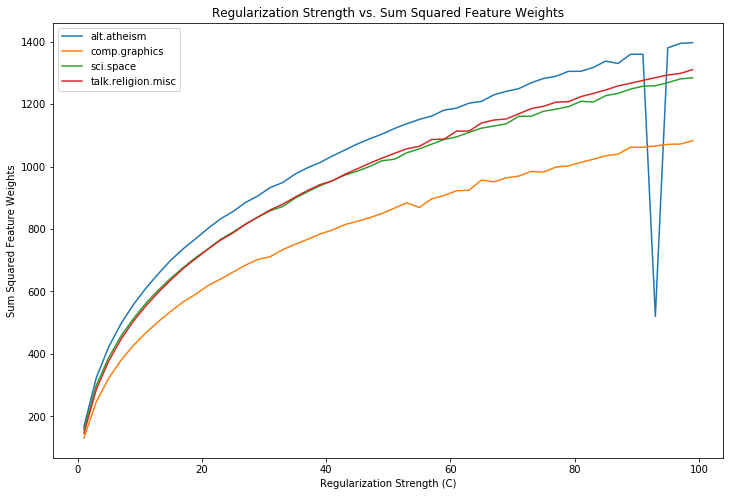

In [5]:
### STUDENT START ###
def P3():
    
    v = CountVectorizer()
    f = v.fit_transform(train_data)
    scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
    
    ## k-NN classifier
    # Use kNN classifier and optimize the number of neighbors using grid 
    # search with the f1-score as the scoring metric
    print '\nK-NEAREST NEIGHBORS MODEL:\n'
    start = time.time()
    
    # n_neighbors was tested over a much larger range, but the optimal 
    # value was found in the range below, so I shortened the search 
    # range to improve runtime
    params = {'n_neighbors': np.arange(90, 100)}
    gs = GridSearchCV(KNeighborsClassifier(), params, scoring=scorer)
    gs.fit(f, train_labels)
    end = time.time()
    print 'Best k:', gs.best_params_.values()[0]
    print 'Best F1-score:', gs.best_score_ 
    print 'runtime:', round(end-start, 3)

    ## Multinomial NB
    # Use the multinomial Naive Bayes classifier and optimize the alpha 
    # value using grid search with the f1-score as the scoring metric
    print '\nMULTINOMIAL NAIVE BAYES MODEL:\n'
    start = time.time()
    
    # alpha was tested over a much larger range, but the optimal 
    # value was found in the range below, so I shortened the search 
    # range to improve runtime
    params = {'alpha': np.arange(0.0, 0.01, 0.0001)}
    gs = GridSearchCV(MultinomialNB(), params, scoring=scorer)
    gs.fit(f, train_labels)
    end = time.time()
    print 'Best alpha:', gs.best_params_.values()
    print 'Best F1-score:', gs.best_score_ 
    print 'runtime:', round(end-start, 3)
    
    ## Logistic Regression
    # Use logistic regression and optimize the regularization strength
    # using grid search with the f1-score as the scoring metric
    print '\nLOGISTIC REGRESSION MODEL:\n'
    start = time.time()
    
    # regularization strength was tested over a much larger range, but 
    # the optimal value was found in the range below, so I shortened the
    # search range to improve runtime
    params = {'C': np.arange(0.1, .2, 0.01)}
    gs = GridSearchCV(LogisticRegression(), params, scoring=scorer)
    gs.fit(f, train_labels)
    end = time.time()
    print 'Best regularization parameter:', gs.best_params_.values()
    print 'Best F1-score:', gs.best_score_ 
    print 'runtime:', round(end-start, 3)
    
    ## Part C: 
    # describe the relationship between accuracy and the sum of the 
    # squared weights
    print '\nPART C:\n'
    labels = newsgroups_train['target_names']
    start = time.time()
    
    # the relationship between sumsq weights and C for the range tested
    # above is just linear because it is over such a small range of 
    # values, so I expanded the range of C to see a more interesting
    # relationship between accuracy and sumsq weights
    ssq_total = []
    for c in np.arange(1,100,2):
        
        # fit a logistic regression model with regularization strength c
        lg = LogisticRegression(C=c)
        lg.fit(f, train_labels)
        
        # Take the sum of the squared weights for each label for each 
        # value of c and append it to a list
        weights = lg.coef_
        ssq = np.sum(weights**2, axis=1)
        ssq_total.append(ssq)
    # convert to a numpy array
    ssq_total = np.array(ssq_total)
    print 'runtime:', time.time() - start
    
    # plot the regularization strength vs. the sum of the squared
    # weights for each label
    C = np.arange(1,100,2)
    plt.figure(figsize=(12,8))
    for i in range(4):
        plt.plot(C, ssq_total[:,i])
    plt.title('Regularization Strength vs. Sum Squared Feature Weights')
    plt.xlabel('Regularization Strength (C)')
    plt.ylabel('Sum Squared Feature Weights')
    plt.legend([labels[0], labels[1], labels[2], labels[3]])

P3()
### STUDENT END ###

ANSWER:  

 a) The nearest neighbors model doesn't work very well in this scenario because there aren't any neighbors that are very near. By this I mean that the vectorized features are a sparse matrix so a large majority of the data that is used as nearest neighbors will be empty or at least not contain meaningful information. This is why the optimal number of neighbors was so high at 96, because we need to include that many points in the sparse matrix to have a few points of meaningful information
    
 b) 
    
 c) The relationship between the regularization strength, C, and the sum of squared weights is somewhat logarithmic. This makes sense because the regularization strength is a penalty to the total size of the weight to ensure that the sum squared weight does not become too large and thus overfit the data. So if the regularization is growing linearly, then the sum squared weights must grow less than linearly, but will still be growing, and this shows in the curve.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [11]:
### STUDENT START ###

# the below function generates a word map which maps the top 5 words to 
# their index in the logistic regression coefficient matrix. Then using 
# those indices, find the coefficient/weight of each word for each 
# label. The function returns a pandas DataFrame with the rownames as 
# the array of top 5 words for each label, the columns names as each 
# label, and the entries as the weight of that word for each label
def P4(train_data, train_labels, grams=(1,1)):
    
    # get the target labels
    labels = newsgroups_train['target_names']
    
    # vectorize the data and extract the vocabulary
    v = CountVectorizer(ngram_range=grams)
    f = v.fit_transform(train_data)
    vocab = v.vocabulary_
    
    # fit the logisitic regression to extract the coefficients (weights) 
    # of the feature vectors
    lg = LogisticRegression(C=0.18)
    lg.fit(f, train_labels)
    
    # generate the weight map
    word_map = {}
    words = []
    for ind,c in enumerate(lg.coef_):
        
        # find the top 5 words by weight for each label.
        top5 = np.argsort(c)[::-1][:5]
        words = [(k, v) for k,v in vocab.items() if v in top5]
        
        # store top 5 for each label in single word map
        for w in words:
            word_map[w[0]] = w[1]
    
    # grab the weights at the indices in the word map
    weight_arr = np.array([
        [lg.coef_[i][v] for v in word_map.values()] 
        for i in range(len(labels))
    ])
    
    # generate the DataFrame
    df = pd.DataFrame(weight_arr.T, columns=labels, index=word_map.keys())
    
    return df

### STUDENT END ###
df1 = P4(train_data, train_labels)
df2 = P4(train_data, train_labels, grams=(2,2))
df3 = P4(train_data, train_labels, grams=(1,2))
print '\nUnigram features only:\n'
print df1
print '\nBigram features only:\n'
print df2
print '\nUnigram and Bigram features:\n'
print df3


Unigram features only:

            alt.atheism  comp.graphics  sci.space  talk.religion.misc
christian     -0.330484      -0.238977  -0.217520            0.672245
religion       0.596010      -0.367913  -0.482972           -0.015839
image         -0.329160       0.802789  -0.468117           -0.269745
bobby          0.597084      -0.146222  -0.208707           -0.282748
space         -0.793108      -0.849346   1.467190           -0.716614
orbit         -0.263077      -0.410297   0.735836           -0.329093
launch        -0.263923      -0.298331   0.581582           -0.207426
atheism        0.596496      -0.257976  -0.255648           -0.305634
atheists       0.582813      -0.085958  -0.195574           -0.399363
spacecraft    -0.215581      -0.230584   0.502490           -0.186686
computer      -0.011247       0.660631  -0.411370           -0.283164
blood         -0.282313      -0.076331  -0.135759            0.570613
file          -0.207927       0.781722  -0.511770           -0.35

ANSWER: For each label, the 5 words that have the strongest weight for that label carry very strong positive coefficients which is to be expected. What is interesting is that the other 15 words that best represent the other 3 labels carry strong negative coefficients for that label, which indicates that the regression has identified the strong indicators for each label and weighted them negatively for every other label which helps to reinforce the classification. Additionally, the use of bigrams only chooses some interesting selections as the most important words for each label. With unigrams only, the words that were selected made good llogical sense that they would carry strong weight for that label (e.g. 'nasa' for sci.space, 'christian' for talk.religion.misc, and 'atheism' for alt.atheism). The bigram features are harder to logically justify. Why is 'cheers kent' the strongest indicator of the label alt.atheism? How is 'and such' a strong indicator of sci.space? In running the regression with both unigrams and bigrams, it becomes apparent that these aren't actually that strong of indicators as the 20 word list in this regression contains nearly the same words as it does when using just unigrams, indicating that the bigram features do not influence the classification very as strongly as the unigram features

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [132]:
tester = "this is a TEST 928347 string I've made with .prj file 8257@blue.cis.pitt.edu, 745hg"
print tester
tester = better_preprocessor(tester)
print tester
re.findall(u'(?u)\\b\\w\\w+\\b', tester)

this is a TEST 928347 string I've made with .prj file 8257@blue.cis.pitt.edu, 745hg
this is a test numeric_string string ive made with .prj file 8257@blue.cis.pitt.edu, 745hg


['this',
 'is',
 'test',
 'numeric_string',
 'string',
 'ive',
 'made',
 'with',
 'prj',
 'file',
 '8257',
 'blue',
 'cis',
 'pitt',
 'edu',
 '745hg']

In [142]:
### STUDENT START ###

def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    s = s.lower()
    s = re.sub(r"\s+\d+\s+", " numeric_string ", s)
    s = re.sub(r"\'", "", s)
    s = re.sub(r"\w+@\w+[\.\w+]+", " email_string ", s)
    
    return s

In [143]:
def P5():
    # using the empty_preprocessor
    v = CountVectorizer(preprocessor=empty_preprocessor)
#     v = CountVectorizer()
    f = v.fit_transform(train_data)
    vocab1 = v.vocabulary_
    d = v.transform(dev_data)
    lg = LogisticRegression(C=0.18)
    lg.fit(f, train_labels)
    pred = lg.predict(d)
    print '\nF1-score with empty preprocessor:', metrics.f1_score(dev_labels, pred, average='weighted')
    print len(vocab1.keys())
    
    # using the better_preprocessor
    v = CountVectorizer(preprocessor=better_preprocessor)
    f = v.fit_transform(train_data)
    vocab2 = v.vocabulary_
    d = v.transform(dev_data)
    lg = LogisticRegression(C=0.18)
    lg.fit(f, train_labels)
    pred = lg.predict(d)
    print '\nF1-score with better preprocessor:', metrics.f1_score(dev_labels, pred, average='weighted')
    print len(vocab2.keys())
    
    return vocab1, vocab2

vocab1, vocab2 = P5()

### STUDENT END ###


F1-score with empty preprocessor: 0.7067777804938987
33291

F1-score with better preprocessor: 0.7145733917630118
26197


In [127]:
vocab1

{u'3ds2scn': 1179,
 u'ADEOS': 2173,
 u'EXPLAIN': 5376,
 u'luanch': 24366,
 u'circuitry': 17345,
 u'phenomenologist': 26676,
 u'hanging': 22065,
 u'localized': 24255,
 u'LAST': 8081,
 u'Western': 14072,
 u'Roelle': 11468,
 u'Successor': 12651,
 u'pigment': 26769,
 u'Y14': 14308,
 u'bringing': 16687,
 u'Signatures': 12249,
 u'vibrational': 32515,
 u'Samelovich': 11950,
 u'Larsen': 8244,
 u'HAPPENED': 6655,
 u'preface': 27201,
 u'cfa': 17157,
 u'270': 867,
 u'miniatures': 24961,
 u'272': 868,
 u'273': 870,
 u'274': 872,
 u'275': 874,
 u'276': 876,
 u'277': 877,
 u'279': 880,
 u'targa': 30996,
 u'errors': 20294,
 u'Initially': 7442,
 u'rle': 28781,
 u'usenet': 32270,
 u'Quickdraw': 10944,
 u'designing': 19050,
 u'televangelists': 31096,
 u'College': 4245,
 u'succumb': 30632,
 u'shocks': 29527,
 u'evolutionism': 20427,
 u'widget': 32910,
 u'UTKVX': 13467,
 u'SPY': 11794,
 u'Enzo': 5575,
 u'brainwashed': 16637,
 u'47': 1298,
 u'affiliated': 15057,
 u'Octopus': 9873,
 u'Heines': 6872,
 u'natu

In [128]:
vocab2

{u'3ds2scn': 74,
 u'raining': 17613,
 u'elvs': 7110,
 u'foul': 8659,
 u'luanch': 12934,
 u'four': 8669,
 u'compatable': 4447,
 u'circuitry': 3956,
 u'reagon': 17776,
 u'phenomenologist': 16171,
 u'hanging': 9742,
 u'ringlets': 18625,
 u'localized': 12792,
 u'disobeying': 6392,
 u'milchstrasse_': 13782,
 u'unnecessarily': 22832,
 u'rickman': 18590,
 u'immature': 10668,
 u'sinking': 19895,
 u'propane': 17153,
 u'rashly': 17673,
 u'flower': 8468,
 u'oceans': 15116,
 u'thermoelectric': 21799,
 u'pigment': 16298,
 u'portugals': 16628,
 u'politician': 16545,
 u'bringing': 3040,
 u'disturb': 6476,
 u'basics': 2310,
 u'vibrational': 23311,
 u'wednesday': 23717,
 u'vlba': 23446,
 u'photopolarimter': 16228,
 u'woods': 24037,
 u'cheeto': 3816,
 u'commented': 4353,
 u'bill': 2615,
 u'specially': 20330,
 u'matthean': 13418,
 u'p_i': 15629,
 u'combnation': 4314,
 u'preface': 16821,
 u'p_c': 15628,
 u'error_': 7502,
 u'feasibility': 8169,
 u'miniatures': 13839,
 u'everbody': 7651,
 u'ate1': 1902,
 u'

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

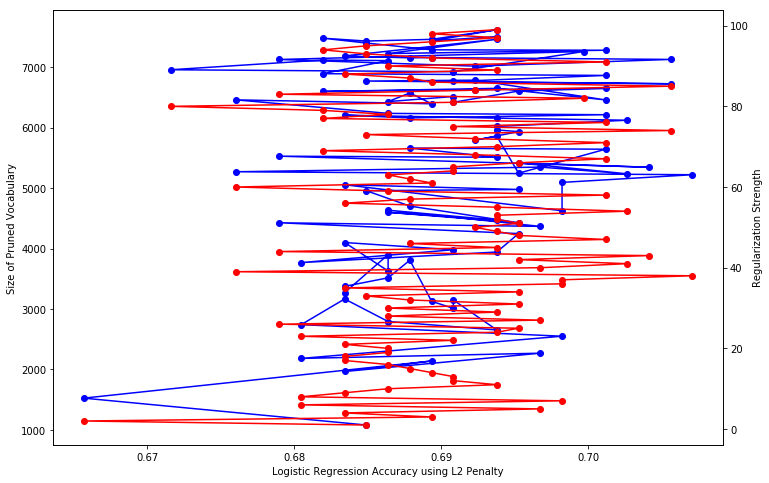

In [6]:
### STUDENT START ###
def P6(c_vals):
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    acc = []
    vocab_size = []
    for c in c_vals:
        # step 1: build the L1 model
        v = CountVectorizer()
        f = v.fit_transform(train_data)
        vocab = v.vocabulary_
        lg1 = LogisticRegression(penalty='l1', tol=0.01, C=c)
        lg1.fit(f, train_labels)

        # step 2: prune the vocab
        i,j = np.where(lg1.coef_ != 0)
        vocab_pruned = {k:v for k,v in vocab.items() if v in j}
        vocab_size.append(len(vocab_pruned.keys()))

        # step 3: train an L2 model with pruned vocab
        v2 = CountVectorizer(vocabulary=vocab_pruned.keys())
        f2 = v2.fit_transform(train_data)
        p = v2.fit_transform(dev_data)
        lg2 = LogisticRegression(penalty='l2', tol=0.01, C=c)
        lg2.fit(f2, train_labels)
        pred = lg2.predict(p)
        acc.append(metrics.accuracy_score(dev_labels, pred))
    
#     fig, ax1 = plt.subplots(figsize=(12,8))
#     ax2 = ax1.twinx()
# #     ax1.plot(vocab_size, acc, 'bo-')
# #     ax2.plot(vocab_size, c_vals, 'ro-')
#     ax1.plot(acc, vocab_size, 'bo-')
#     ax2.plot(acc, c_vals, 'ro-')
#     ax1.set_ylabel('Size of Pruned Vocabulary')
#     ax1.set_xlabel('Logistic Regression Accuracy using L2 Penalty')
#     ax2.set_ylabel('Regularization Strength')
    plt.figure(figsize=(12,8))
    plt.plot(acc, vocab_size, 'o-')
    plt.xlabel('Logistic Regression Accuracy using L2 Penalty')
    plt.ylabel('Size of Pruned Vocabulary')
    return acc, vocab_size

c_vals = np.arange(1,100,2)
acc, vocab_size = P6(c_vals)
### STUDENT END ###

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [20]:
help(TfidfVectorizer)

Help on class TfidfVectorizer in module sklearn.feature_extraction.text:

class TfidfVectorizer(CountVectorizer)
 |  Convert a collection of raw documents to a matrix of TF-IDF features.
 |  
 |  Equivalent to CountVectorizer followed by TfidfTransformer.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : string {'filename', 'file', 'content'}
 |      If 'filename', the sequence passed as an argument to fit is
 |      expected to be a list of filenames that need reading to fetch
 |      the raw content to analyze.
 |  
 |      If 'file', the sequence items must have a 'read' method (file-like
 |      object) that is called to fetch the bytes in memory.
 |  
 |      Otherwise the input is expected to be the sequence strings or
 |      bytes items are expected to be analyzed directly.
 |  
 |  encoding : string, 'utf-8' by default.
 |      If bytes or files are given to analyze, this encoding is used to
 |      decode.
 |

In [11]:
#def P7():
    ### STUDENT START ###



    ### STUDENT END ###
#P7()

ANSWER:

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance